# Problem 1

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/oskarva/.local/lib/python3.10/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/d6307a5c5fbd484dbfdeec0cb5899dab-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /tmp/d6307a5c5fbd484dbfdeec0cb5899dab-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 5 COLUMNS
At line 15 RHS
At line 16 BOUNDS
At line 20 ENDATA
Problem MODEL has 0 rows, 3 columns and 0 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 0 - 0.00 seconds
Cgl0004I processed model has 0 rows, 0 columns (0 integer (0 of which binary)) and 0 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from 0 to -1.79769e+308
Probing was tried 0 times and created 0 cuts of which 0 were active after adding rounds of cuts (0.000 seconds)
Gomory was tried 0 times and created 0 cuts of wh

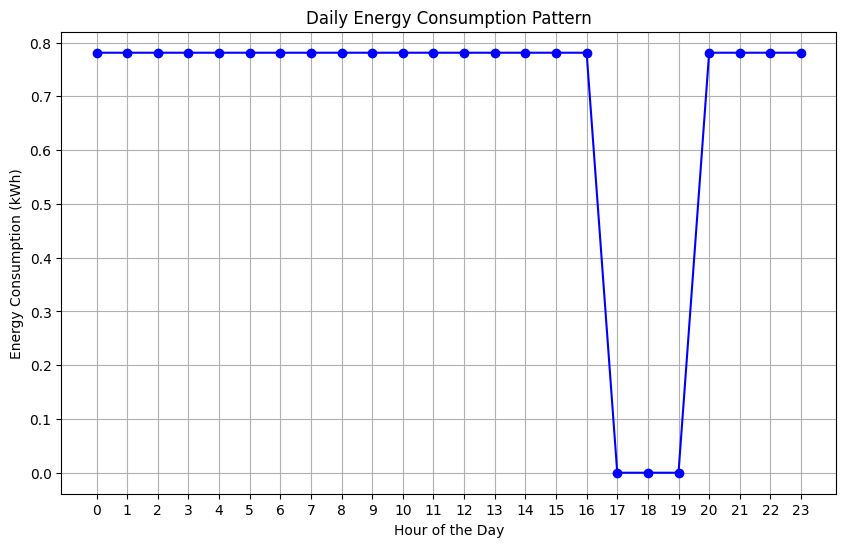

In [119]:
from pulp import LpProblem, LpMinimize, LpVariable, LpBinary, value
import matplotlib.pyplot as plt

#define the problem
prob = LpProblem("Minimize_Energy_Cost", LpMinimize)

#decision variables for whether each appliance runs during peak hours (binary: 0 or 1)
x1 = LpVariable("WashingMachineDuringPeak", 0, 1, LpBinary)
x2 = LpVariable("EVDuringPeak", 0, 1, LpBinary)
x3 = LpVariable("DishwasherDuringPeak", 0, 1, LpBinary)

#define the objective function (total cost)
prob += (x1 * 1 + (1 - x1) * 0.5) * 1.94 + (x2 * 1 + (1 - x2) * 0.5) * 9.9 + (x3 * 1 + (1 - x3) * 0.5) * 1.44
prob.solve()

print("Total Cost:", value(prob.objective))

#extracting decisions
washing_machine_peak = x1.value()
ev_peak = x2.value()
dishwasher_peak = x3.value()

#define energy consumption patterns
energy_consumption = [0] * 24  # Initialize with 0 kWh for each hour

#assign energy consumption for each appliance based on solver's decision
#peak hours are 17 to 20, not including 20

if washing_machine_peak: #value 1 == runs during peak
    for hour in range(17, 20):
        energy_consumption[hour] += 1.94 / 3  #spread evenly across peak hours
else:
    #spread washing machine consumption evenly in off-peak hours (excluding 17-20)
    for hour in range(0, 17):
        energy_consumption[hour] += 1.94 / 17
    for hour in range(20, 24):
        energy_consumption[hour] += 1.94 / 17

if ev_peak:
    for hour in range(17, 20):
        energy_consumption[hour] += 9.9 / 3  #spread evenly across peak hours
else:
    for hour in range(0, 17):
        energy_consumption[hour] += 9.9 / 17
    for hour in range(20, 24):
        energy_consumption[hour] += 9.9 / 17

if dishwasher_peak:
    for hour in range(17, 20):
        energy_consumption[hour] += 1.44 / 3  #spread evenly across peak hours
else:
    for hour in range(0, 17):
        energy_consumption[hour] += 1.44 / 17
    for hour in range(20, 24):
        energy_consumption[hour] += 1.44 / 17

hours = list(range(24))
plt.figure(figsize=(10, 6))
plt.plot(hours, energy_consumption, marker='o', linestyle='-', color='b')
plt.title('Daily Energy Consumption Pattern')
plt.xlabel('Hour of the Day')
plt.ylabel('Energy Consumption (kWh)')
plt.xticks(hours)
plt.grid(True)
plt.show()


# Plotting price curve for task 1 

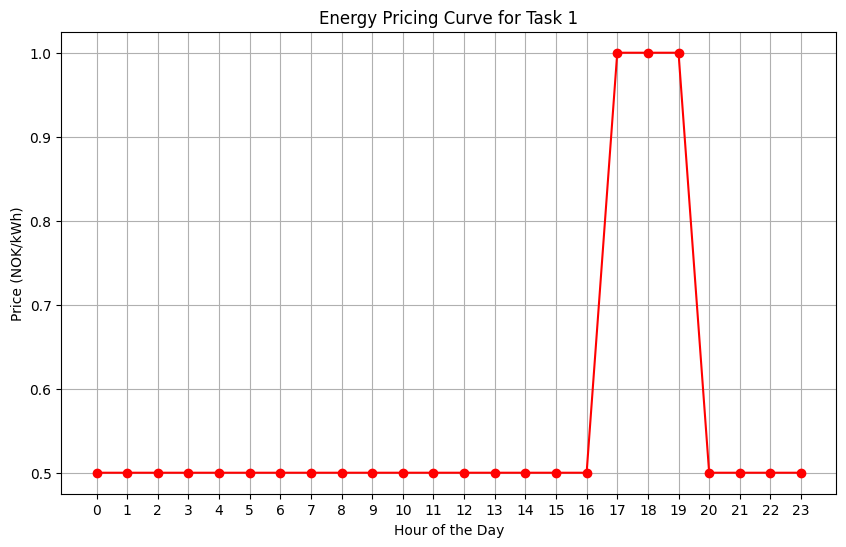

In [120]:
peak_price = 1  # NOK/kWh
off_peak_price = 0.5  # NOK/kWh
hours = list(range(24))

#assigning the price for each hour
prices = [off_peak_price if hour < 17 or hour >= 20 else peak_price for hour in hours]

plt.figure(figsize=(10, 6))
plt.plot(hours, prices, marker='o', linestyle='-', color='r')
plt.title('Energy Pricing Curve for Task 1')
plt.xlabel('Hour of the Day')
plt.ylabel('Price (NOK/kWh)')
plt.xticks(hours)
plt.grid(True)
plt.show()

## Create price curve and plot it

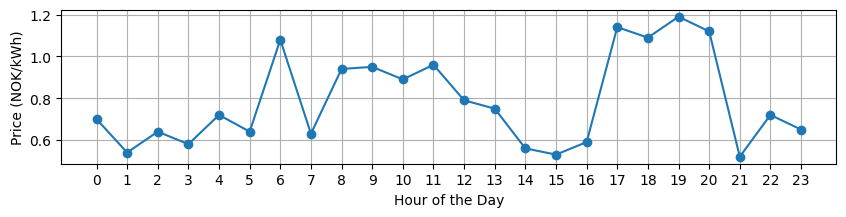

In [121]:
import random
import matplotlib.pyplot as plt
import numpy as np

random.seed(5410)

def generate_price_curve(peak_hours, morning_hours):
    price_curve = {}
    for hour in range(24):
        if hour in peak_hours:
            price_curve[hour] = round(random.uniform(0.9, 1.3), 2)  # Peak price range: 0.2 to 1.0 NOK/kWh
        elif hour in morning_hours:
            price_curve[hour] = round(random.uniform(0.8, 1.1), 2)
        else:
            price_curve[hour] = round(random.uniform(0.5, 0.8), 2)  # Default to off-peak price for non-defined hours
    return price_curve

# Define peak and off-peak hours (for example)
peak_hours = {17, 18, 19, 20}  # 5:00 pm to 8:00 pm
morning_hours = {6, 8, 9, 10, 11}

# Generate a random price curve
price_curve = generate_price_curve(peak_hours, morning_hours)

# Plot the generated price curve
plt.figure(figsize=(10, 2))
plt.plot(price_curve.keys(), price_curve.values(), marker='o', linestyle='-')
# plt.title("RTC Price Curve")
plt.xlabel("Hour of the Day")
plt.ylabel("Price (NOK/kWh)")
plt.grid(False)
plt.xticks(range(24))
plt.grid(True)
plt.savefig("rtp.eps")
plt.show()


## Problem 2

In [122]:
import pyomo.environ as pe

l_h = 0.1 #hourly consumption of incandescent lighting kWh
h_h = 9.6/24 #hourly consumption of heating kWh
r_h = 3.96/24 #hourly consumption of refrigerator kWh
s_h = 3.9/3 #hourly consumption of stove kWh
tv_h = 0.6/5 #hourly consumption of refrigerator kWh
pc_h = 0.6/4 #hourly consumption of pc kWh
rout_h = 0.006 #hourly consumption of wifi router kWh
cm_h = 0.3 #hourly consumption of coffee maker kWh
toast_h = 0.6 #hourly consumption of toaster kWh



In [123]:
#Energy consumption for non-shiftable appliances per appliance, per hour kWh
x_ns = np.asarray([[l_h if i >= 10 and i < 20 else 0 for i in range(24)],
                   [h_h for i in range(24)],
                   [r_h for i in range(24)],
                   [s_h if (i>=19  and i<21) or (i>=13 and i<14) else 0 for i in range(24)],
                   [tv_h if i>=17 and i<22 else 0 for i in range(24)],
                   [pc_h if i>=17 and i<21 else 0 for i in range(24)],
                   [rout_h for i in range(24)],
                   [cm_h if i>=7 and i<9 else 0 for i in range(24)],
                   [toast_h if i>=7 and i<9 else 0 for i in range(24)]])

ns_app_names = ["Lighting","Heating","Refrigerator","Stove","TV","PC","Router","Coffee Maker","Toaster"]
app_names = ['Dish Washer', 'Washing Machine', 'Tumble Dryer','EV']
E         = [1.44, 1.94, 2.5, 9.9] #daily energy consumption of the 4 shiftable appliances, kWh
power_lim = [1.8, 1, 3 , 3.6] #power rate of these appliances. I have just searched them online when not available at reference 2. The EV one is taken from the lesson slides, for a nissan leaf. in kWh

m = pe.ConcreteModel()

m.nt    = pe.Param(initialize = len(price_curve), domain=pe.Integers)
m.T     = pe.Set(initialize = range(m.nt()))
m.price = pe.Param(m.T, initialize = price_curve)
m.I     = pe.RangeSet(0,len(E)-1)

m.x_s   = pe.Var(m.I, m.T, domain=pe.NonNegativeReals) #hourly energy consumption of shiftable appliance i at hour t

# Define objective function
def obj_rule(model):
    # Add cost of non-shiftable appliances
    total_cost = sum(model.price[t] * (sum(model.x_s[i, t] for i in model.I) + sum(x_ns[i, t] for i in range(len(x_ns)))) for t in model.T)
    return total_cost

m.obj = pe.Objective(rule=obj_rule, sense=pe.minimize)

m.cons = pe.ConstraintList() #create a list of constraints
for i in m.I:
  m.cons.add(expr = sum(m.x_s[i,t] for t in m.T)==E[i]) #constraint for total daily energy use
  for t in m.T:
    m.cons.add(expr = m.x_s[i,t] <= power_lim[i])
m.cons.add(expr = sum(m.x_s[3,t] for t in range(8,18))==0) #charging hours constraint of EV
  
results = pe.SolverFactory('cbc').solve(m)

# Extract the solution values
solution_values = {(i, t): pe.value(m.x_s[i, t]) for i in m.I for t in m.T}

# Data for shiftable appliances
shiftable_sum = [sum(solution_values[i, t] for i in range(len(app_names))) for t in m.T]

# Data for non-shiftable appliances
non_shiftable_sum = [sum(x_ns[i, t] for i in range(len(ns_app_names))) for t in m.T]

# Sum of shiftable and non-shiftable appliances
total_sum = [shiftable_sum[t] + non_shiftable_sum[t] for t in range(len(m.T))]


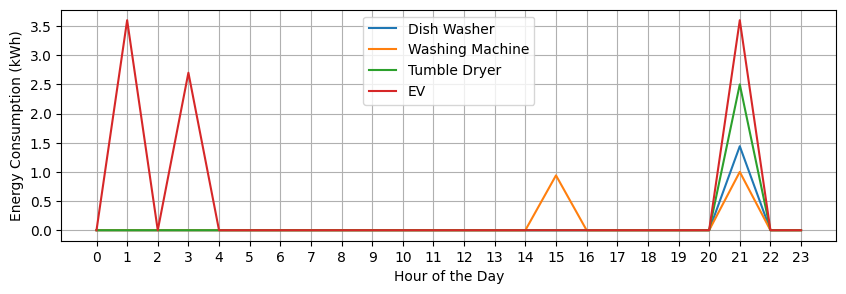

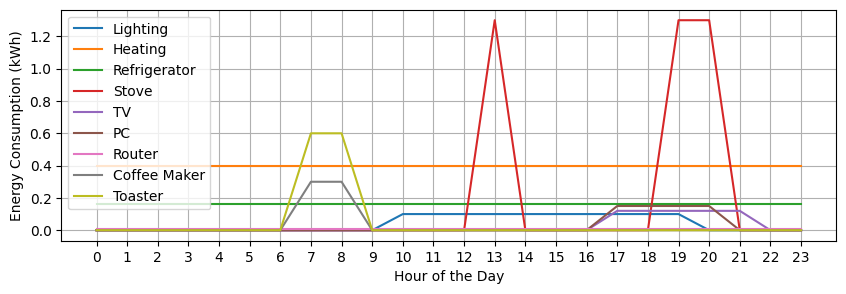

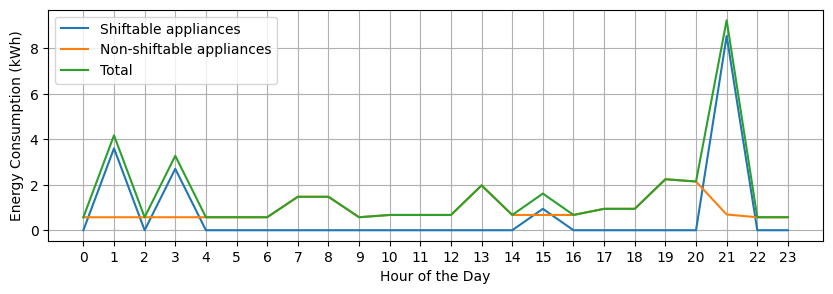

26.780519999999996


In [124]:
# Plot the energy consumption profile
plt.figure(figsize=(10, 3))
for i in range(len(E)):
    plt.plot(range(len(m.T)), [solution_values[i, t] for t in m.T], label=f"{app_names[i]}")
# plt.title("Energy Consumption Profile of Shiftable Appliances")
plt.xlabel("Hour of the Day")
plt.ylabel("Energy Consumption (kWh)")
plt.xticks(range(len(m.T)))
plt.legend()
plt.grid(True)
plt.savefig("shift.png", transparent=False, bbox_inches='tight')
plt.show()

plt.figure(figsize=(10, 3))
for i in range(len(ns_app_names)):
    plt.plot(range(len(m.T)), [x_ns[i, t] for t in m.T], label=f"{ns_app_names[i]}")
# plt.title("Energy Consumption Profile of Non-Shiftable Appliances")
plt.xlabel("Hour of the Day")
plt.ylabel("Energy Consumption (kWh)")
plt.xticks(range(len(m.T)))
plt.legend()
plt.grid(True)
plt.savefig("nonshift.png", transparent=False, bbox_inches='tight')
plt.show()

plt.figure(figsize=(10, 3))
plt.plot(range(len(m.T)), shiftable_sum, label="Shiftable appliances")
plt.plot(range(len(m.T)), non_shiftable_sum, label="Non-shiftable appliances")
plt.plot(range(len(m.T)), total_sum, label="Total")
# plt.title("Total Energy Consumption Profile")
plt.xlabel("Hour of the Day")
plt.ylabel("Energy Consumption (kWh)")
plt.xticks(range(len(m.T)))
plt.legend()
plt.grid(True)
plt.savefig("total.png", transparent=False, bbox_inches='tight')
plt.show()

print(pe.value(sum(m.price[t] * (sum(m.x_s[i, t] for i in m.I) + sum(x_ns[i, t] for i in range(len(x_ns)))) for t in m.T)))

# Problem 3

In [125]:
from pyomo.environ import ConcreteModel, Param, Var, Objective, minimize, ConstraintList, NonNegativeReals, RangeSet, Set, SolverFactory

#assuming the price curve generated in Task 2 is applicable here as well

#constants
NUM_HOUSEHOLDS = 30
EV_OWNERSHIP = 10  #fraction of households own an EV
NUM_APPLIANCES = len(app_names)  #number of shiftable appliances from Problem 2

model = ConcreteModel()

#parameters
model.nt = Param(initialize=len(price_curve))  # Number of time slots
model.T = RangeSet(0, model.nt - 1)  # Set of time slots
model.price = Param(model.T, initialize=price_curve)  # Price curve
model.households = RangeSet(0, NUM_HOUSEHOLDS - 1)  # Set of households
model.appliances = RangeSet(0, NUM_APPLIANCES - 1)  # Set of appliances

#variable to model energy consumption of appliance i in household j at time t
model.x_s = Var(model.appliances, model.households, model.T, domain=NonNegativeReals)

#objective: Minimize total energy cost for all households
def total_cost_rule(model):
    # Cost of using shiftable appliances, iterating over appliances, households, and time
    shiftable_cost = sum(model.price[t] * sum(model.x_s[i, j, t] for i in model.appliances for j in model.households) for t in model.T)
    # Assuming x_ns[i, t] already considers all households, simply sum over it directly
    non_shiftable_cost = sum(model.price[t] * x_ns[i, t] for i in range(len(x_ns)) for t in model.T)
    # Total cost
    return shiftable_cost + non_shiftable_cost


model.total_cost = Objective(rule=total_cost_rule, sense=minimize)

#constraints
model.constraints = ConstraintList()

for j in model.households:
    for i in model.appliances:
        if app_names[i] == 'EV' and j < NUM_HOUSEHOLDS - EV_OWNERSHIP:
            #for households without an EV, set the daily energy requirement for the EV to 0
            model.constraints.add(sum(model.x_s[i, j, t] for t in model.T) == 0)
        else:
            #for all other appliances or households with an EV, enforce the standard daily energy requirement
            model.constraints.add(sum(model.x_s[i, j, t] for t in model.T) == E[i])
            model.constraints.add(expr = sum(model.x_s[3, j, t] for t in range(8,18)) == 0) #Car is not home during these hours
        for t in m.T:
            model.constraints.add(expr = model.x_s[i,j,t] <= power_lim[i])

#solve the model
solver = SolverFactory('cbc')
results = solver.solve(model)



#### Adding results to a csv

In [126]:
import pandas as pd

solution_values = {(app, house, t): pe.value(model.x_s[app, house, t]) for app in model.appliances for house in model.households for t in model.T}


#transform the dictionary into a DataFrame for easier manipulation and exporting
df = pd.DataFrame(list(solution_values.items()), columns=['Key', 'Energy Consumption'])
df[['Appliance', 'Household', 'Time Slot']] = pd.DataFrame(df['Key'].tolist(), index=df.index)
df.drop(columns=['Key'], inplace=True)

#reorder the DataFrame columns
df = df[['Appliance', 'Household', 'Time Slot', 'Energy Consumption']]

#remove rows where Energy Consumption is 0 to reduce sparsity
df_non_zero = df[df['Energy Consumption'] > 0]

#pivot the table to have one row per (Household, Appliance) pair and columns for each time slot
pivoted_df = df_non_zero.pivot_table(index=['Household', 'Appliance'], 
                                     columns='Time Slot', 
                                     values='Energy Consumption', 
                                     fill_value=0)

#reset the index to turn the MultiIndex back into columns (optional)
pivoted_df.reset_index(inplace=True)

#flatten the columns to remove the multi-level structure introduced by pivot_table
pivoted_df.columns = [str(col) if not isinstance(col, tuple) else f'Time Slot {col[1]}' for col in pivoted_df.columns.values]

#export to CSV
pivoted_df.to_csv('./out/pivoted_energy_consumption.csv', index=False)

##### The model ended up just putting all of the energy usage in four different timeslots. As a result, we might as well just plot the energy usage as a bar chart.

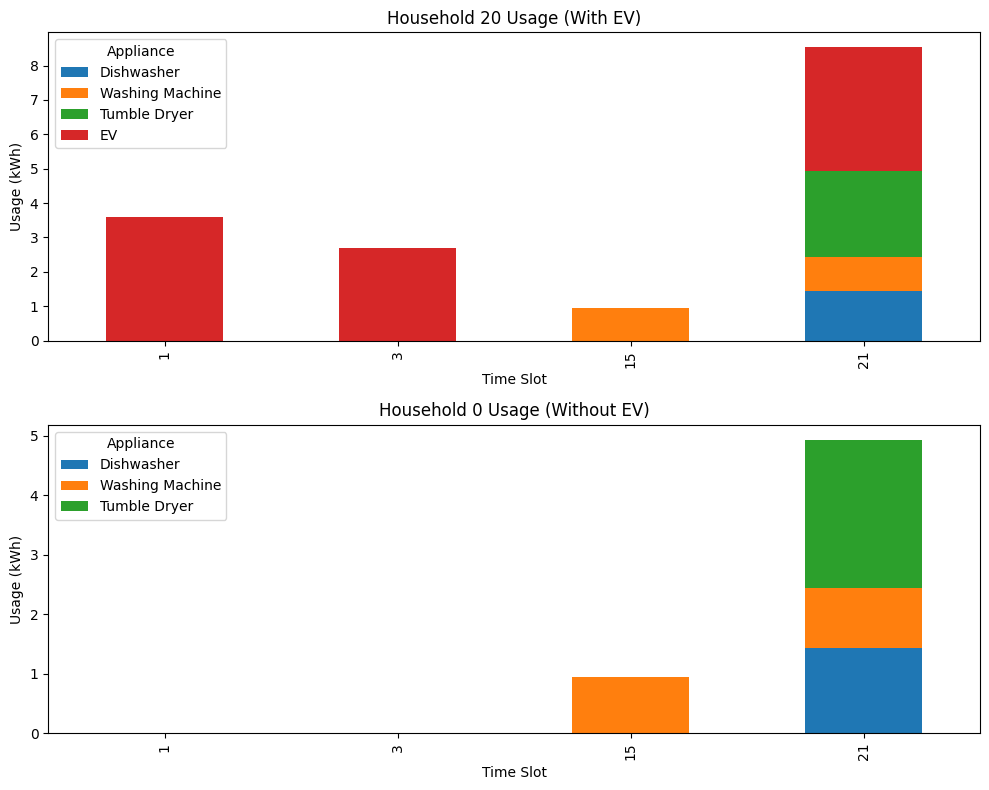

In [127]:
import pandas as pd
import matplotlib.pyplot as plt

df = pivoted_df
ev_appliance_id = 3

#finding households with and without an ev
household_with_ev = df[df['Appliance'] == ev_appliance_id]['Household'].unique()
household_without_ev = [household for household in df['Household'].unique() if household not in household_with_ev]

#selecting a house witg and one without an EV for demonstration
house_with_ev = household_with_ev[0] if household_with_ev.size > 0 else None
house_without_ev = household_without_ev[0] if len(household_without_ev) > 0 else None

appliance_names = {0: 'Dishwasher', 1: 'Washing Machine', 2: 'Tumble Dryer', 3: 'EV'}

#applying descriptive names to the 'Appliance' column
df['Appliance'] = df['Appliance'].map(appliance_names)

#plotting
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

#plot for household with EV
if house_with_ev is not None:
    df_house_ev = df[df['Household'] == house_with_ev].set_index('Appliance').drop('Household', axis=1).T
    df_house_ev.plot(ax=axs[0], kind='bar', stacked=True, title=f'Household {house_with_ev} Usage (With EV)')
    axs[0].set_ylabel('Usage (kWh)')
    axs[0].set_xlabel('Time Slot')

#plot for household without EV
if house_without_ev is not None:
    df_house_no_ev = df[df['Household'] == house_without_ev].set_index('Appliance').drop('Household', axis=1).T
    df_house_no_ev.plot(ax=axs[1], kind='bar', stacked=True, title=f'Household {house_without_ev} Usage (Without EV)')
    axs[1].set_ylabel('Usage (kWh)')
    axs[1].set_xlabel('Time Slot')

plt.tight_layout()
plt.show()


#### Checking if all non-EV households have the same energy consumption patterns, and vice versa with EV households 

In [128]:
import pandas as pd

file_path = './out/pivoted_energy_consumption.csv'
df_full = pd.read_csv(file_path)

ev_appliance_id = 3

#check if the 'Appliance' column contains the EV identifier
has_ev = df_full['Appliance'] == ev_appliance_id

#separate the df into EV and non-EV households
ev_households = df_full[has_ev]['Household'].unique()
print("EV households:",ev_households)
non_ev_households = df_full[~has_ev]['Household'].unique()
print("Non-EV households:",non_ev_households)

#removing rows with the EV appliance from the df before identifying unique patterns for non-EV households
df_without_ev = df_full[~df_full['Appliance'].isin([ev_appliance_id])]

#grouping by 'Household' to get unique patterns excluding the EV appliance
non_ev_unique_patterns = df_without_ev.groupby('Household').apply(lambda x: x.set_index('Appliance').drop('Household', axis=1)).drop_duplicates()

#grouping by 'Household' to get unique patterns including the EV appliance for EV households
ev_unique_patterns = df_full[df_full['Household'].isin(ev_households)].groupby('Household').apply(lambda x: x.set_index('Appliance').drop('Household', axis=1)).drop_duplicates()

print("\n\nAll unique non-ev household energy consumption patterns:\n",non_ev_unique_patterns)
print("\n\nAll unique EV household energy consumption patterns:\n",ev_unique_patterns)



EV households: [20 21 22 23 24 25 26 27 28 29]
Non-EV households: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]


All unique non-ev household energy consumption patterns:
                        1    3    15    21
Household Appliance                      
0         0          0.0  0.0  0.00  1.44
          1          0.0  0.0  0.94  1.00
          2          0.0  0.0  0.00  2.50


All unique EV household energy consumption patterns:
                        1    3    15    21
Household Appliance                      
20        0          0.0  0.0  0.00  1.44
          1          0.0  0.0  0.94  1.00
          2          0.0  0.0  0.00  2.50
          3          3.6  2.7  0.00  3.60


##### As we can see from the results above, there is only ONE unique energy consumption pattern for non-EV households, and only one unique pattern for EV households. 

# Problem 4

Slope: 0.84, Intercept: 3.44, R-value: 0.999, P-value: 0.00, Standard Error: 0.03


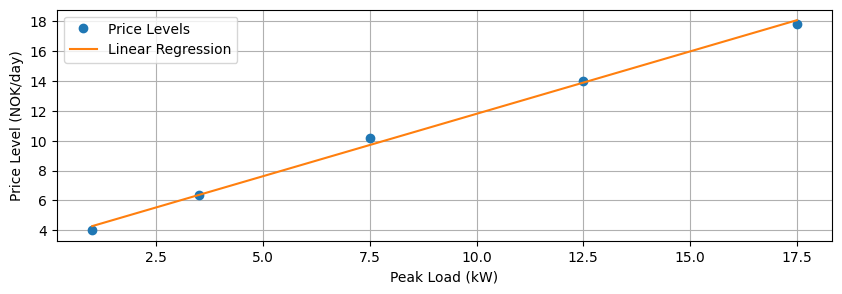

In [129]:
from scipy import stats 

#Price levels for peak load ranges (nok and kW) taken from Elvia, divided by 30 to represent daily price
price_levels = np.array([120, 190, 305, 420, 535])/30
ranges = np.array([[0, 2], [2, 5], [5, 10], [10, 15], [15, 20]])

# Calculate the midpoints of each range
midpoints = (ranges[:, 0] + ranges[:, 1]) / 2

slope, intercept, r_value, p_value, std_err = stats.linregress(midpoints,price_levels)

Y_pred = intercept + midpoints * slope

print(f"Slope: {slope:.2f}, Intercept: {intercept:.2f}, R-value: {r_value:.3f}, P-value: {p_value:.2f}, Standard Error: {std_err:.2f}")

# Plotting
plt.figure(figsize=(10, 3))
plt.plot(midpoints, price_levels, 'o', label='Price Levels')
plt.plot(midpoints, Y_pred, label='Linear Regression')
plt.xlabel('Peak Load (kW)')
plt.ylabel('Price Level (NOK/day)')
# plt.title('Linear Regression of Fastledd Price Levels')
plt.legend()
plt.grid(True)
plt.savefig("pricelvl.png")
plt.show()

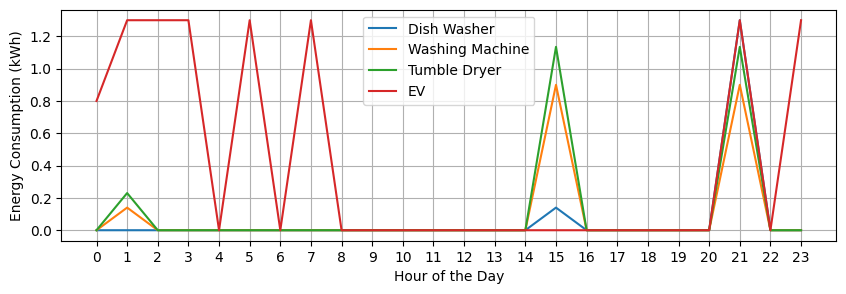

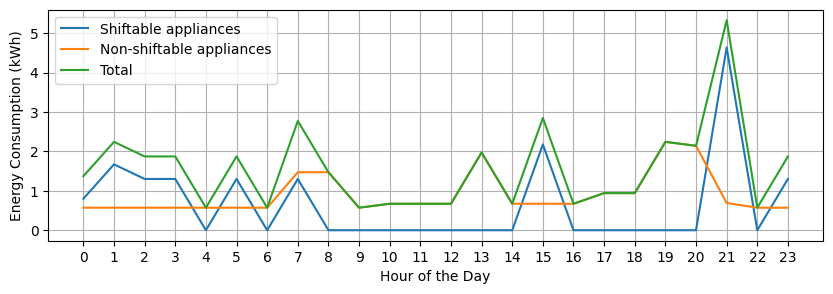

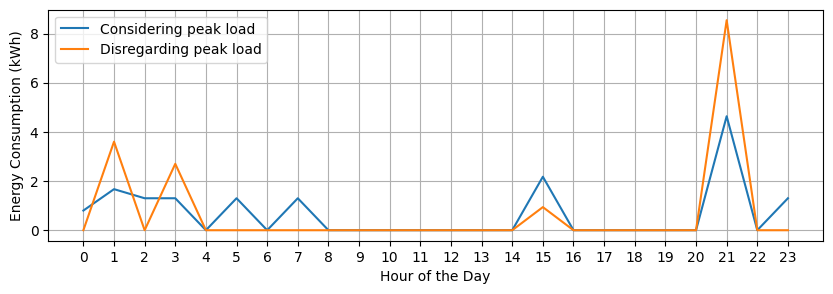

27.438269999999996


In [130]:
m = pe.ConcreteModel()

m.nt    = pe.Param(initialize = len(price_curve), domain=pe.Integers)
m.T     = pe.Set(initialize = range(m.nt()))
m.price = pe.Param(m.T, initialize = price_curve)
m.I     = pe.RangeSet(0,len(E)-1)

m.x_s   = pe.Var(m.I, m.T, domain=pe.NonNegativeReals) #hourly energy consumption of shiftable appliance i at hour t
m.L     = pe.Var(domain=pe.NonNegativeReals)

# Define objective function
def obj_rule(model):
    # Add cost of non-shiftable appliances
    total_cost = sum(model.price[t] * (sum(model.x_s[i, t] for i in model.I) + sum(x_ns[i, t] for i in range(len(x_ns)))) for t in model.T)
    peak_load_cost = intercept + slope*m.L #add fastledd cost related to peak load
    
    return total_cost + peak_load_cost

m.obj = pe.Objective(rule=obj_rule, sense=pe.minimize)

m.cons = pe.ConstraintList() #create a list of constraints
for i in m.I:
  m.cons.add(expr = sum(m.x_s[i,t] for t in m.T)==E[i]) #constraint for total daily energy use
  for t in m.T:
    m.cons.add(expr = m.x_s[i,t] <= power_lim[i]) #constraint for appliance power limit
    m.cons.add(expr = m.x_s[i,t] + x_ns[i,t] <= m.L) #constraint for peak load
m.cons.add(expr = sum(m.x_s[3,t] for t in range(8,18))==0) #charging hours constraint of EV
  
results = pe.SolverFactory('cbc').solve(m)

# Extract the solution values
solution_values = {(i, t): pe.value(m.x_s[i, t]) for i in m.I for t in m.T}

# Data for shiftable appliances
shiftable_sum_q4 = [sum(solution_values[i, t] for i in range(len(app_names))) for t in m.T]

# Data for non-shiftable appliances
non_shiftable_sum = [sum(x_ns[i, t] for i in range(len(ns_app_names))) for t in m.T]

# Sum of shiftable and non-shiftable appliances
total_sum = [shiftable_sum_q4[t] + non_shiftable_sum[t] for t in range(len(m.T))]

# Plot the energy consumption profile
plt.figure(figsize=(10, 3))
for i in range(len(E)):
    plt.plot(range(len(m.T)), [solution_values[i, t] for t in m.T], label=f"{app_names[i]}")
# plt.title("Energy Consumption Profile of Shiftable Appliances With Peak Load")
plt.xlabel("Hour of the Day")
plt.ylabel("Energy Consumption (kWh)")
plt.xticks(range(len(m.T)))
plt.legend()
plt.grid(True)
plt.savefig("shift_q4.png", transparent=False, bbox_inches='tight')
plt.show()

plt.figure(figsize=(10, 3))
plt.plot(range(len(m.T)), shiftable_sum_q4, label="Shiftable appliances")
plt.plot(range(len(m.T)), non_shiftable_sum, label="Non-shiftable appliances")
plt.plot(range(len(m.T)), total_sum, label="Total")
# plt.title("Total Energy Consumption Profile With Peak Load")
plt.xlabel("Hour of the Day")
plt.ylabel("Energy Consumption (kWh)")
plt.xticks(range(len(m.T)))
plt.legend()
plt.grid(True)
plt.savefig("total_q4.png", transparent=False, bbox_inches='tight')
plt.show()

plt.figure(figsize=(10, 3))
plt.plot(range(len(m.T)), shiftable_sum_q4, label="Considering peak load")
plt.plot(range(len(m.T)), shiftable_sum, label="Disregarding peak load")
# plt.title("Comparison of Energy Consumption of Shiftable Devices According to Peak Load Considerations")
plt.xlabel("Hour of the Day")
plt.ylabel("Energy Consumption (kWh)")
plt.xticks(range(len(m.T)))
plt.legend()
plt.grid(True)
plt.savefig("shift_com.png", transparent=False, bbox_inches='tight')
plt.show()

print(pe.value(sum(m.price[t] * (sum(m.x_s[i, t] for i in m.I) + sum(x_ns[i, t] for i in range(len(x_ns)))) for t in m.T)))